# Setup and config

In [1]:
# Import packages
import numpy as np
import struct
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

from torchvision import datasets
from torchsummary import summary

import argparse

In [2]:
from CNN.plotting import visualize_activations, get_single_image

In [3]:
# Imports own code
from CNN.backend import load_or_train_CNN, Net, pred_single_image
from CNN.plotting import plot_confusion_matrix, plot_loss
from SVD.back import visualize_svd, compute_svd_per_digit, classify_image, load_or_run_all_ranks
import KNN.func as knn

In [4]:
# Set pathing
path_raw_data = Path.cwd() / 'data'/ 'MNIST' / 'raw'
path_download = Path.cwd() / 'data'

path_svd = Path.cwd() / 'SVD'
path_knn = Path.cwd() / 'KNN'
path_CNN_results = Path.cwd() / 'CNN' / 'results'

In [5]:
# Download data if not already present (pytorch implementation)
# Put in data folder earlier described
# d1 and d2 are dummy variables besides that!
_d1 = datasets.MNIST(path_download, train=True, download=True)
_d2 = datasets.MNIST(path_download, train=False)

# Common code 

In [6]:
# Logic handling the importing of images straight from the files.

# Load images from the MNIST dataset
def load_image_file(filename):
    with open(filename, 'rb') as f:
        # Skip the magic number and number of images
        _, num_images = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))  # Image dimensions
        # Read image data and reshape into (num_images, rows*cols)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
    return {'n': num_images, 'x': images}

# Load labels from the MNIST dataset
def load_label_file(filename):
    with open(filename, 'rb') as f:
        # Skip the magic number and number of labels
        _, num_labels = struct.unpack(">II", f.read(8))
        # Read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load training and test datasets
def load_mnist(folder: Path):
    train = load_image_file(folder / 'train-images-idx3-ubyte')
    test = load_image_file(folder /'t10k-images-idx3-ubyte')
    
    train['y'] = load_label_file(folder / 'train-labels-idx1-ubyte')
    test['y'] = load_label_file(folder / 't10k-labels-idx1-ubyte')
    
    return train, test

# Display an MNIST digit image
def show_digit(arr784):
    plt.imshow(arr784.reshape(28, 28), cmap='gray')
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()



In [7]:
# Loading data
# Load MNIST data
train, test = load_mnist(path_raw_data)

# EDA

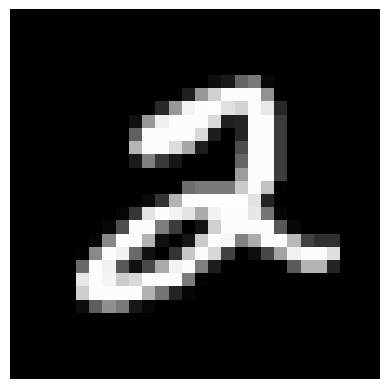

In [8]:
# Display an example image (e.g., the 5th training image)
show_digit(train['x'][5])

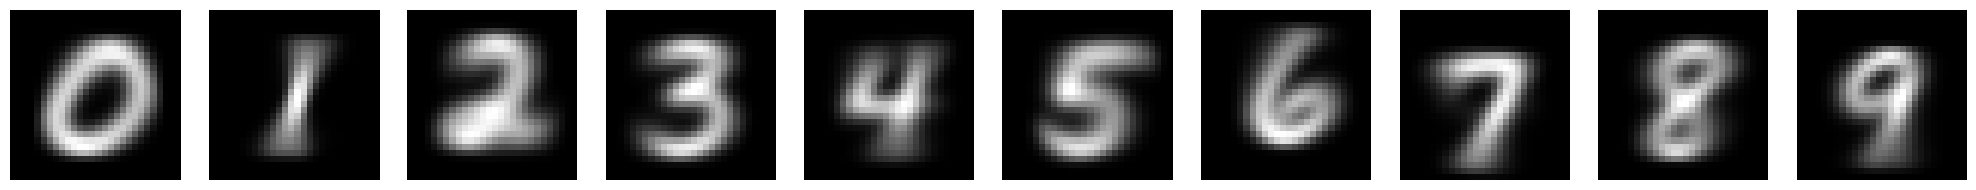

In [9]:
# Visualize the average of all digits

averages = knn.average_images(train['x'], train['y'])
imgs = [np.array(averages[0][i]) for i in range(10)]
avg_img_array = [img.reshape(28,28) for img in imgs]
knn.show_digits(avg_img_array)


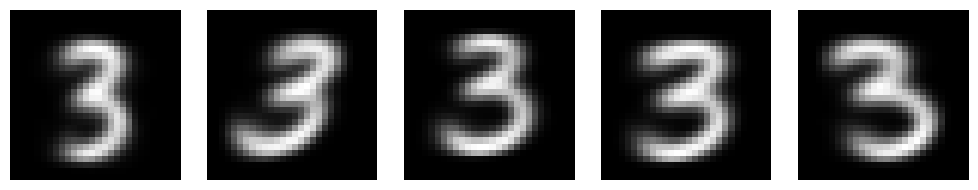

In [10]:
# Cluster centroids for digit 3 (5 centroids)
data = [train['x'][i] for i in range(len(train['x'])) if train['y'][i] == 3]
kmeans = KMeans(n_clusters = 5).fit(data)
centers = kmeans.cluster_centers_
arr_centers = [center.reshape(28,28) for center in centers]

knn.show_digits(arr_centers)

In [11]:
centers
np.shape(centers)

(5, 784)

In [12]:
test_labels = load_label_file(path_raw_data / 't10k-labels-idx1-ubyte')
test_images = load_image_file(path_raw_data /  't10k-images-idx3-ubyte')

print(f"Number of test labels: {len(test_labels)}")
print(f"Number of test images: {len(test_images)}")

print(test_labels)

train_labels = load_label_file( path_raw_data / 'train-labels-idx1-ubyte')
train_images = load_image_file(path_raw_data /  'train-images-idx3-ubyte')
train_labels
train['y'][5]

Number of test labels: 10000
Number of test images: 2
[7 2 1 ... 4 5 6]


2

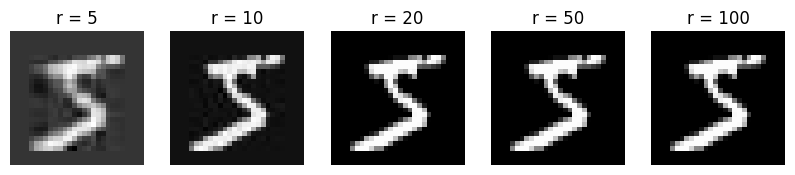

In [13]:
visualize_svd(train['x'][0])

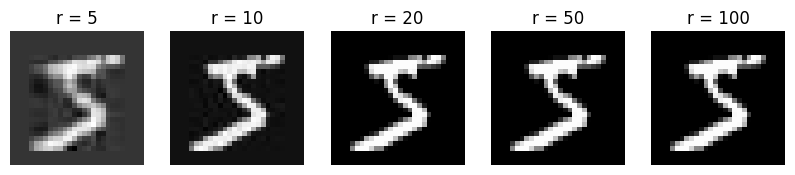

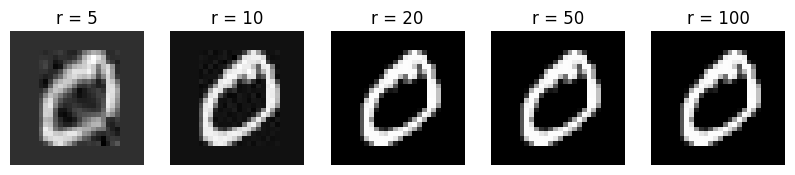

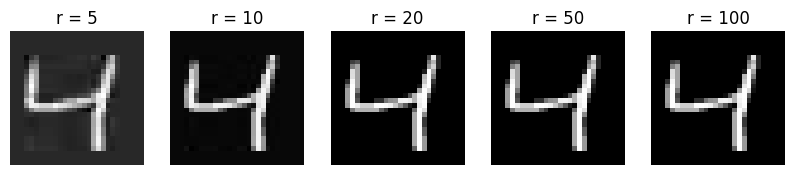

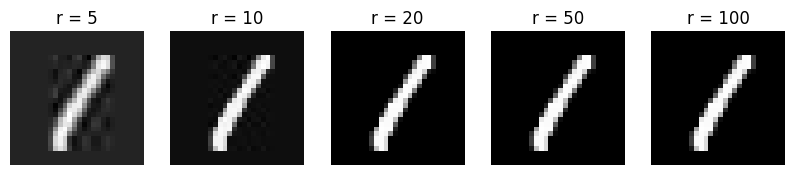

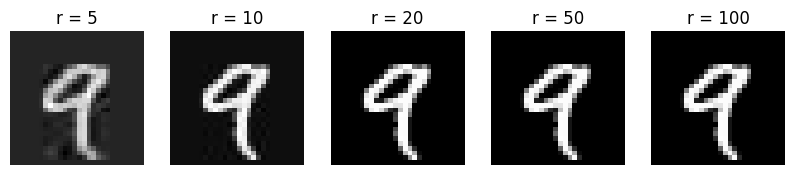

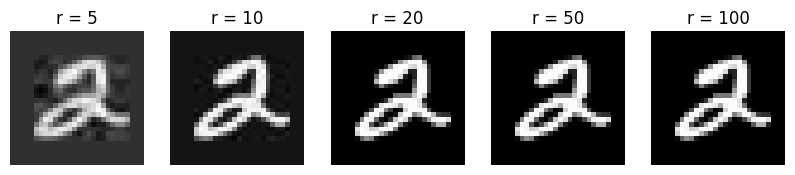

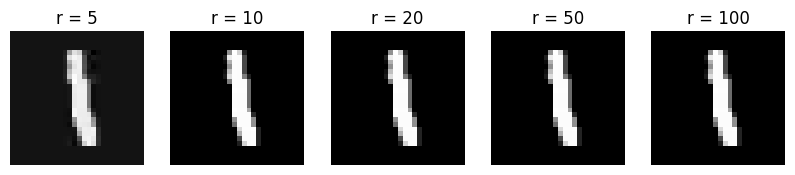

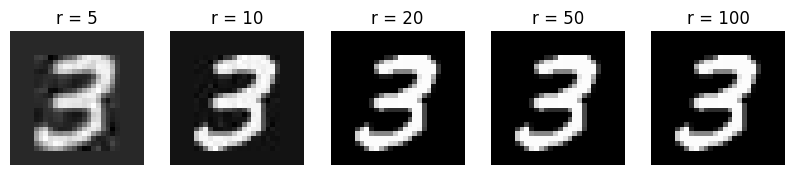

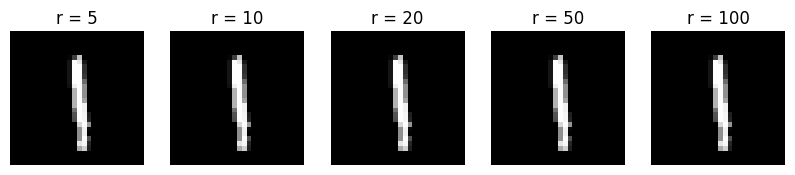

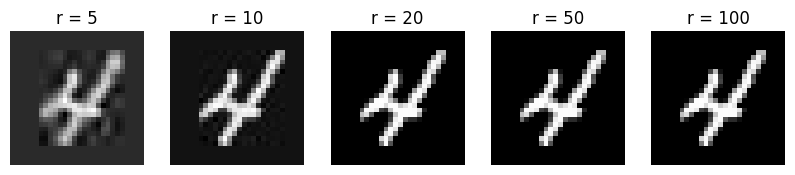

In [14]:
#Example image
for i in range(0,10):
    visualize_svd(train['x'][i])

# CNN

In [15]:
# Load / Define model / Set up settings for the model. 
parser = argparse.ArgumentParser(description='PyTorch MNIST Example');
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=25, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10000, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')

_StoreTrueAction(option_strings=['--save-model'], dest='save_model', nargs=0, const=True, default=True, type=None, choices=None, help='For Saving the current Model', metavar=None)

In [16]:
# An architecture overview of the model
# For further details, check the Net class in the backend.py file (there you will see a few more details)
_model = Net()
summary(_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 26, 26]             300
            Conv2d-2           [-1, 60, 24, 24]          16,260
           Dropout-3           [-1, 60, 12, 12]               0
            Linear-4                  [-1, 128]       1,106,048
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,123,898
Trainable params: 1,123,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 4.29
Estimated Total Size (MB): 4.78
----------------------------------------------------------------


In [17]:
# Load or train the model
# Can set force to true if you want to force it to retrain
results, model = load_or_train_CNN(path_CNN_results, path_download, force=False, parser=parser)

Loaded previous results from file

Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99%)


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99%)

Now let us check if accuracy is the same as the one we calculated from the weights
     Loaded vs calculated
Best accuracy 99.22 vs 99.22
Final accuracy 99.22 vs 99.22
It took 4.1237654999999975 seconds to calculate the predictions
That is an average of 0.00041237654999999975 seconds per image


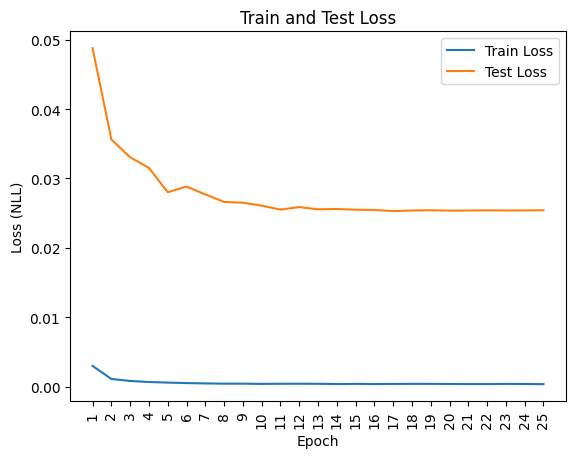

In [18]:
# Plot losses
plot_loss(results=results, save_folder= path_CNN_results, show=True)

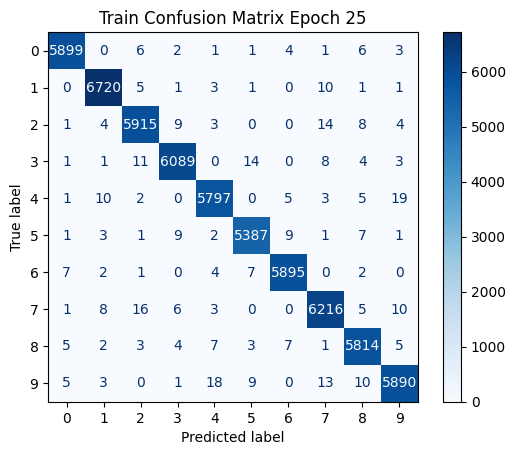

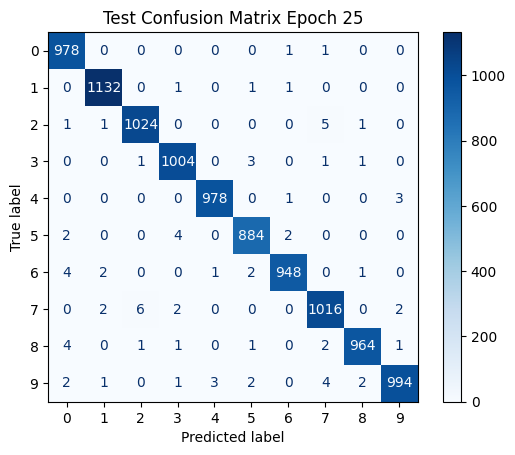

In [19]:
# Plot confusion matrices of the last epoch
max_epoch = results["epochs"]
plot_confusion_matrix(results=results, epoch=max_epoch, save_folder=path_CNN_results, show=True)

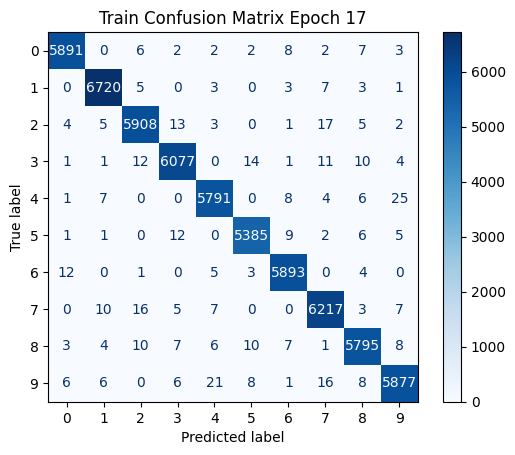

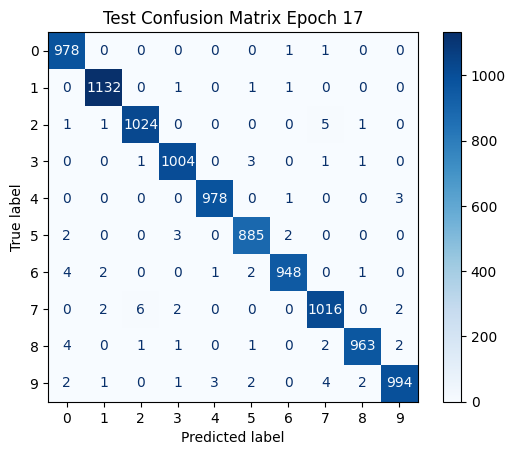

In [20]:
# Plot confusion matrices of the best epoch
best_epoch = results["best_epoch"]
plot_confusion_matrix(results=results, epoch=best_epoch, save_folder=path_CNN_results, show=True)

In [21]:
# Neatly print the most important results.
print(f"Prep time: {results['prep_time']} seconds, prediction time: {results['predict_time']} seconds, (average of {results['predict_time']/10000}) seconds") 
      
print(f"Accuracy in best epoch: {results['best_epoch_accuracy']}, Accuracy in final epoch: {results['final_epoch_accuracy']}")

Prep time: 1094.4476399 seconds, prediction time: 3.0678903999998965 seconds, (average of 0.00030678903999998967) seconds
Accuracy in best epoch: 99.22, Accuracy in final epoch: 99.22


In [22]:
results, model = load_or_train_CNN(path_CNN_results, path_download, force=False, parser=parser)

Loaded previous results from file

Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99%)


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99%)

Now let us check if accuracy is the same as the one we calculated from the weights
     Loaded vs calculated
Best accuracy 99.22 vs 99.22
Final accuracy 99.22 vs 99.22
It took 4.1149573 seconds to calculate the predictions
That is an average of 0.00041149573 seconds per image


In [23]:
# Taking a different look at the average of test time.
t_array = [pred_single_image(download_folder=path_download, results_path=path_CNN_results) for i in range(5000)]

avg_time = sum(t_array)/len(t_array)
avg_time


0.016447899279999872

If you do not want to run the above cell because it takes too long, believe us on our blue eyes (dutchism, I know) that it takes at least 1.5 minutes. 

30
60
60


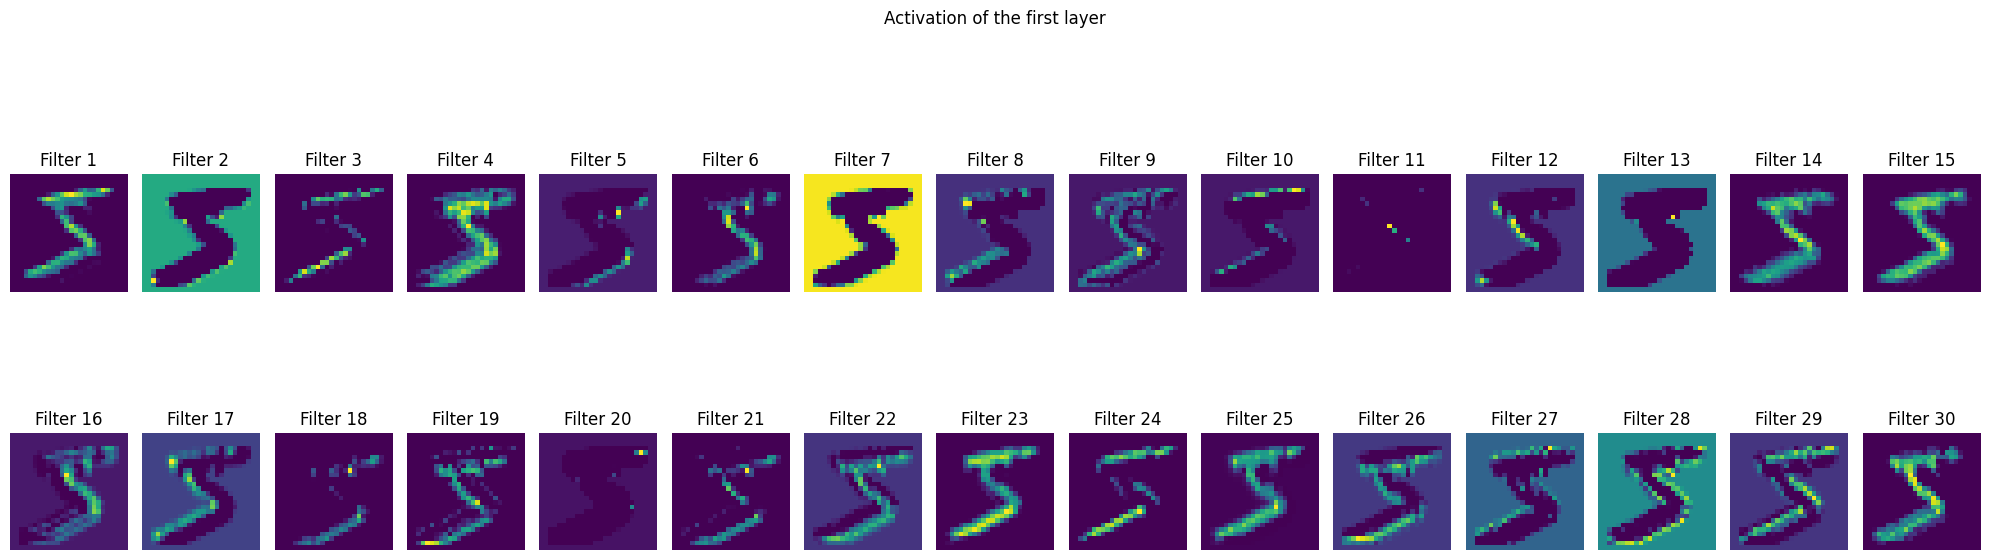

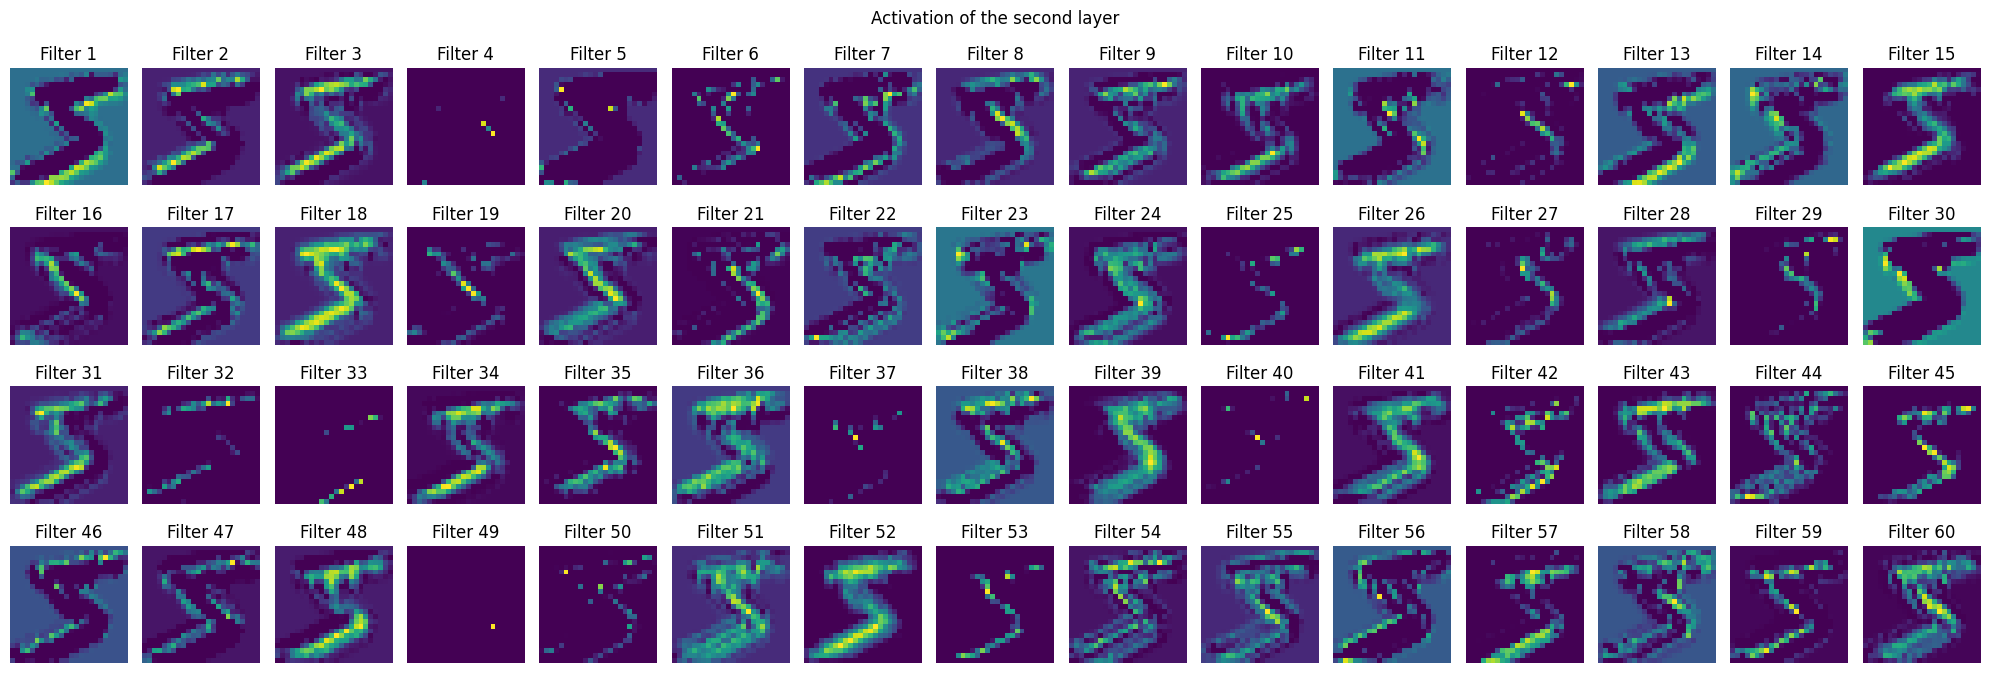

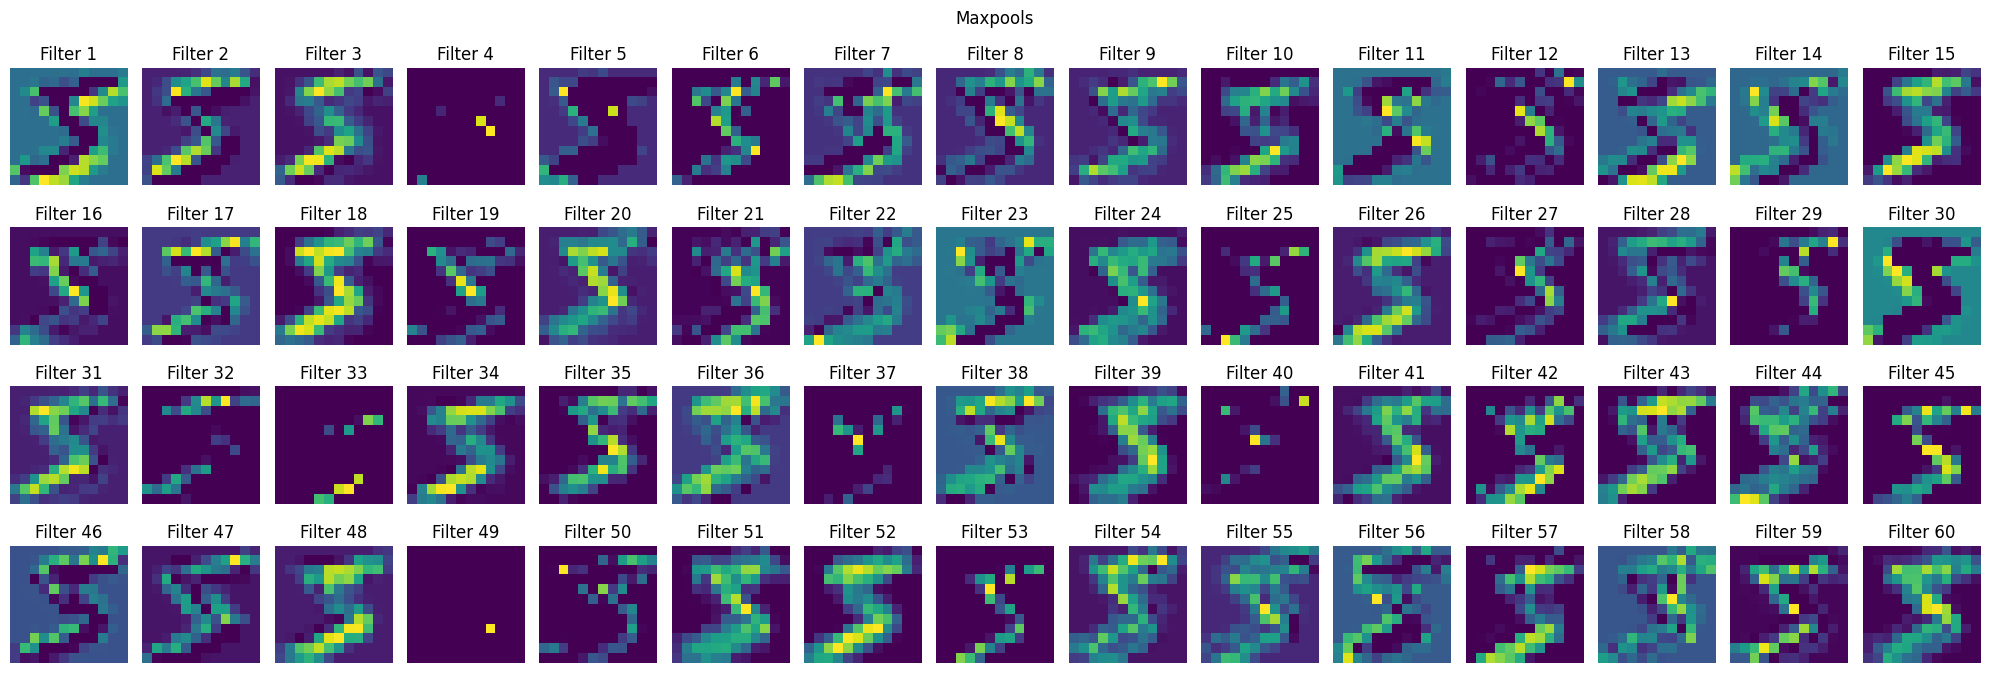

In [24]:
# Get random testing image
img = get_single_image(download_folder=path_download, img_index=5)


visualize_activations(model=_model,input_image=img)

# KNN



First we will go through the final model chosen for this architecture. In a seperate chapter (named optional), some of the old methods will be shown. They are (sometimes), significantly worse, so we do not show their timings, only their accuracies obtained.

In [25]:
setup_start = time.perf_counter()
known_images, known_images_labels = knn.n_centroid_images_each(train['x'], train['y'], 5)
setup_end = time.perf_counter()
setup_time = setup_end - setup_start
print("Setup time: " + str(setup_time))

Setup time: 3.4034227000000215


In [26]:
predictions = []
true_values = [test['y'][i] for i in range(4000, 6000)]
correctness_list = []

In [27]:
exec_start = time.perf_counter()
for i in range(4000, 6000):
    guess = knn.k_nearest_neighbors(known_images, known_images_labels, test['x'][i], 1)
    predictions.append(guess)
    if (guess == test['y'][i]):
        correctness_list.append(1)
    else: correctness_list.append(0)
exec_end = time.perf_counter()
exec_time = exec_end - exec_start
print("Execution time: " + str(exec_time))

accuracy = sum(correctness_list) / len(correctness_list)
print("Accuracy is " + str(accuracy))



Execution time: 37.51233669999999
Accuracy is 0.903


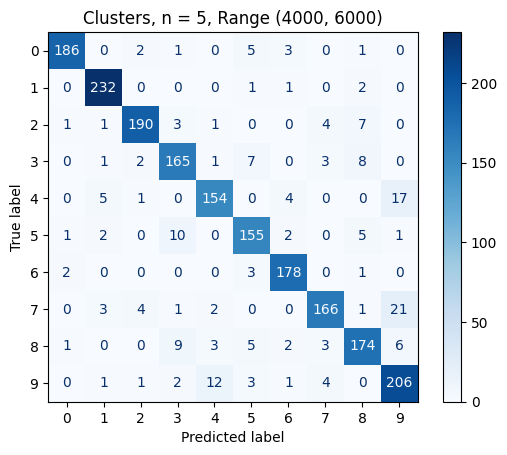

In [28]:
conf_matrix = confusion_matrix(true_values, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [str(i) for i in range(10)])
disp.plot(cmap = plt.cm.Blues)
plt.title("Clusters, n = 5, Range (4000, 6000)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# SVD

The first thing for this section that we do will be time-intensive. So you CAN re-run this next cell, with force=True, to force all the svds to be re-ran, but a pre-ran pickled file will be present to more quickly grab the results. 

In [29]:
# We loop over all (rank 1-9 are omitted because they perform badly) ranks such that we can compute which rank works best
array_t1 = []
array_t2 =[]
accuracy_list = []
array_svd = []

rank_range = [i for i in range(10,31)]
array_t1, array_t2, accuracy_list, array_svd = load_or_run_all_ranks(train, test, rank_range, path_svd)

SVD file exists
SVD file loaded


In [30]:
# Figure out what rank was best performing
max_index = accuracy_list.index(max(accuracy_list))
best_rank = rank_range[max_index]

print(f"The best performing rank is {best_rank} with an accuracy of {accuracy_list[max_index]}")

The best performing rank is 23 with an accuracy of 0.9585


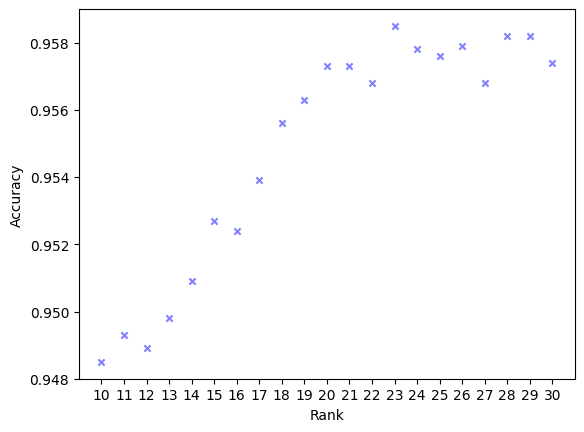

In [31]:
x= np.array(rank_range)
y= np.array(accuracy_list)
plt.xticks(rank_range)
plt.scatter(x, y, color='blue', alpha=0.5, s = 20,marker = 'x')
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.show()

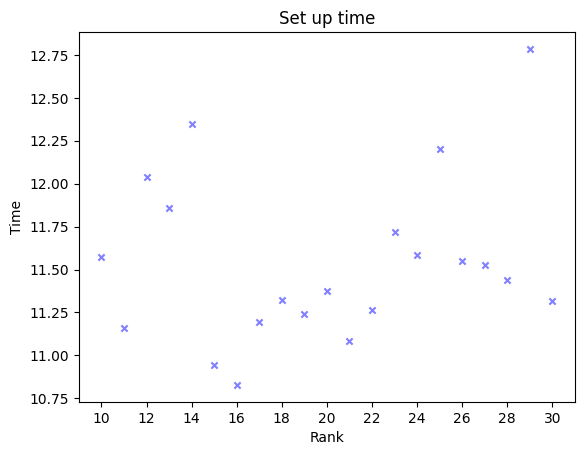

In [32]:
x= np.array(rank_range)
y= np.array(array_t1)
plt.scatter(x, y, color='blue', alpha=0.5, s = 20,marker = 'x')
plt.xlabel('Rank')
plt.ylabel('Time')
plt.title('Set up time')
plt.xticks(np.arange(min(x), max(x)+2, 2))
plt.show()


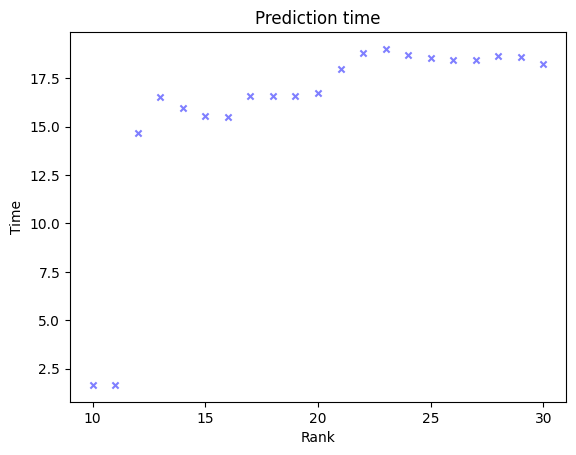

In [33]:
x= np.array(rank_range)
y= np.array(array_t2)
plt.scatter(x, y, color='blue', alpha=0.5, s = 20,marker = 'x')
plt.xlabel('Rank')
plt.ylabel('Time')
plt.title('Prediction time')
plt.xticks(np.arange(min(x), max(x)+2, 5))
plt.show()

We now know that rank 23 is preferred . The accuracy is best and the computation time is not significantly different from other ranks. With this rank we shall do the computations again to get a more accurate depiction of train / test time. And we shall plot a confusion matrix.

In [34]:
# Re-load data, to get a more accurate timing of rank 23 specifically
start_time_1 = time.perf_counter()
train1, test1 = load_mnist(path_raw_data)

r=23  
X_train = train1['x']  # Training images
y_train = train1['y']  # Training labels

X_test = test1['x']  # Test images
y_test = test1['y']  # Test labels

# Compute SVD for each class, digits from 0-9
svd_dict = compute_svd_per_digit(X_train, y_train, r)
end_time_1 = time.perf_counter()

# Compute time taken.
time_1 = end_time_1 - start_time_1
print(f"Ran the SVD operations for rank {r} in {time_1} seconds")

Ran the SVD operations for rank 23 in 11.571566200000007 seconds


In [35]:
# Classify test images again
start_time_2 = time.perf_counter()
train2, test2 = load_mnist(path_raw_data)

r=23  
X_train = train2['x']  # Training images
y_train = train2['y']  # Training labels

X_test = test2['x']  # Test images
y_test = test2['y']  # Test labels
predictions = np.array([classify_image(image, svd_dict) for image in X_test])
accuracy = np.mean(predictions == y_test)
end_time_2 = time.perf_counter()
time_2 = end_time_2 - start_time_2

print(f"Accuracy: {accuracy} with rank:{r}, this took {time_2} seconds")

Accuracy: 0.9585 with rank:23, this took 18.768397899999997 seconds


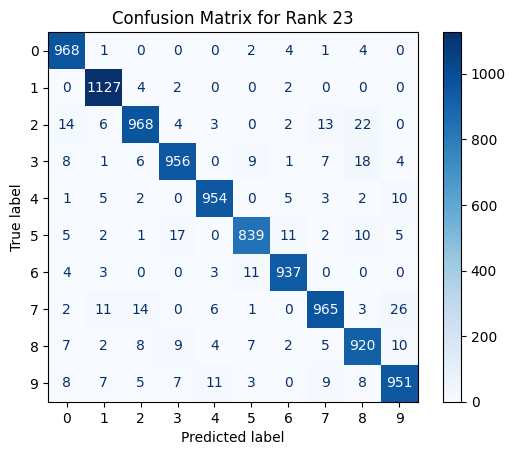

In [36]:
conf_matrix = confusion_matrix(y_test, predictions, labels=np.arange(10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Rank {r}")
plt.show()

# Optional

KNN methods that were tested but werent chosen in the end.

In [37]:
# Look for these three functions in the KNN .py file.

# n_quantiled_averages_each

# n_quantiled_images_each

# n_random_images_each